In [10]:
import sys
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [38]:
polity_df = download_data("https://seshatdata.com/api/core/polities/")
dataset = TSD(categories=['sc',"wf"], file_path="../datasets/power_transitions.csv")

Downloaded 839 rows
Dataset loaded from ../datasets\power_transitions.xlsx


In [39]:
import pyreadr

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)
df['PolityName'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'new_name'].values[0] if x in polity_df['name'].values else np.nan)
df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'id'].values[0] if x in polity_df['name'].values else np.nan)
df.drop_duplicates(subset=['PolityName', 'Year'], inplace=True)
df_old = df.copy()

In [40]:
add_cols = ['Agri','AgriLag']
for col in add_cols:
    dataset.scv[col] = np.nan
# add cols to dataset by merging on PolityID and year from df_agri
for n, row in df.iterrows():
    for col in add_cols:
        dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year']), col] = row[col]
        if len(dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year'])]) > 1:
            print(row['PolityName'], row['Year'])
            

for pol in dataset.scv.PolityName.unique(): 
    for col in add_cols:
        if dataset.scv.loc[dataset.scv['PolityName'] == pol, col].isna().any() and dataset.scv.loc[dataset.scv['PolityName'] == pol, col].notna().any():
            if col == 'Agri':
                dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(method='ffill')
            elif col == 'AgriLag':
                # calculate change in year and add to agrilag value
                agrilag = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), col].iloc[0]
                year = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), 'Year'].iloc[0]
                year_diff = year - dataset.scv.loc[(dataset.scv['PolityName'] == pol), 'Year']
                dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(agrilag - year_diff)

transfer_cols = ["NGA","PolityID","PolityName", "Year", 'Agri','AgriLag','Miltech','IronCav','Cavalry']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

it_st_peter_rep_1 900
it_st_peter_rep_1 900
it_papal_state_4 1700
it_papal_state_4 1700
it_venetian_rep_3 1400
it_venetian_rep_3 1400
eg_new_k_1 -1400
eg_new_k_1 -1400
eg_new_k_2 -1200
eg_new_k_2 -1200
eg_mamluk_sultanate_3 1500
eg_mamluk_sultanate_3 1500
af_kushan_emp 100
af_kushan_emp 100
in_gupta_emp 500
in_gupta_emp 500
kh_angkor_1 1000
kh_angkor_1 1000
cn_northern_song_dyn 1100
cn_northern_song_dyn 1100
jp_yayoi 200
jp_yayoi 200
jp_azuchi_momoyama 1600
jp_azuchi_momoyama 1600
us_hawaii_3 1700
us_hawaii_3 1700
es_spanish_emp_1 1700
es_spanish_emp_1 1700


In [41]:
def get_shifted_values(dataset):
    """
    This function calculates the shifted values for Scale and Comp columns in the dataset.
    It creates new columns for the shifted values and the differences between the current and shifted values.
    Finally it saves the new columns in the dataset.
    """
    dr = dataset.scv_imputed.copy()
    # remove rows without NGA value
    dr = dr.dropna(subset=['NGA'])
    dr['Scale_t'] = np.nan
    dr['d_Scale'] = np.nan
    dr['Comp_t'] = np.nan
    dr['d_Comp'] = np.nan


    dr_nga = dr.groupby('NGA')
    for nga, group in dr_nga:
        group = group.sort_values(['Year', 'PolityID'])
        group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

        # find values 100 years later
        dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
        dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
        dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
        dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
        
        # remove rows without a value 100 yrs later
        mask = (group['Year'].shift(-1) - group['Year'] != 100)
        indices = group.index.intersection(mask[mask].index)

        dr.loc[indices,'Scale_t'] = np.nan
        dr.loc[indices,'Comp_t'] = np.nan
        dr.loc[indices,'d_Scale'] = np.nan
        dr.loc[indices,'d_Comp'] = np.nan
    dataset.scv_imputed = dr.copy()


def sample_polities(dataset):
    n_polities = len(dataset.scv_imputed['PolityName'].unique())
    new_dataset = pd.DataFrame(columns=dataset.scv_imputed.columns)
    for i in range(n_polities):
        # sample polities with replacement
        polity = random.choices(dataset.scv_imputed['PolityName'].unique())[0]
        polity_data = dataset.scv_imputed[dataset.scv_imputed['PolityName'] == polity]
        new_dataset = pd.concat([new_dataset, polity_data])
    new_dataset.reset_index(drop=True, inplace=True)
    return new_dataset

In [42]:
N_imputations = 10
N_boot = 25
# linear_models_scale = pd.DataFrame(columns = ['n_imputations','n_boot', "fit", 'r2', 'r2_adj', 'aic', 'bic'])
linear_models_comp = pd.DataFrame(columns = ['n_imputations','n_boot', "fit", 'r2', 'r2_adj', 'aic', 'bic'])
scv = dataset.scv.copy()
scv_imputed = dataset.scv_imputed.copy()
for n_imputations in range(N_imputations):
    # reset the dataset to the original state
    dataset.scv_imputed = scv_imputed[transfer_cols].copy()
    dataset.scv = scv.copy()

    dataset.scv['Hierarchy_sq'] = dataset.scv['Hierarchy']**2
    # impute scale and non scale variables separately
    scale_cols = ['Pop','Terr','Cap','Hierarchy', 'Hierarchy_sq']
    dataset.impute_missing_values(scale_cols, use_duplicates = False, r2_lim=0., add_resid=True)
    non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
    dataset.impute_missing_values(non_scale_cols, use_duplicates = False, r2_lim=0., add_resid=True)

    scale_pca_cols = ['Pop','Terr','Cap']
    dataset.compute_PCA(cols = scale_pca_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_pca_cols), contributions=False, rescale=False)
    lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
    X = lm_df[['Pop']]
    y = lm_df['Scale_1']

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Extract the coefficients
    intercept = model.intercept_
    slope = model.coef_[0]
    dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope
    comp_mapping = {'Comp':{'Government': 11, 'Infrastructure': 12, 'Information':13, 'Money': 6}}
    dataset.scv_imputed['Comp'] = dataset.scv_imputed.apply(lambda row: weighted_mean(row, comp_mapping,category = 'Comp',imputation = "remove", min_vals=0.5), axis=1)

    dataset.scv = dataset.scv.groupby('dataset').get_group('100y')
    dataset.scv_imputed["dataset"] = dataset.scv["dataset"]
    dataset.scv_imputed = dataset.scv_imputed.groupby('dataset').get_group('100y')
    get_shifted_values(dataset)
    
    for n_boot in range(N_boot):
        x_cols = ['Scale_1','Scale_sq','Agri','IronCav']
        y_col = ['Scale_t']
        Xy = sample_polities(dataset)
        Xy['Scale_sq'] = Xy['Scale_1']**2
        Xy = Xy[y_col+x_cols].dropna()

        Xy['intercept'] = 1
        X = Xy[x_cols+ ['intercept']]
        y = Xy[y_col]

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        model_row = pd.DataFrame([[n_imputations, n_boot, model, model.rsquared, model.rsquared_adj, model.aic, model.bic]], columns = linear_models_scale.columns)
        # linear_models_scale = pd.concat([linear_models_scale, model_row], ignore_index=True)

        x_cols = ['Comp','Comp_sq','Agri','IronCav']
        y_col = ['Comp_t']
        Xy = sample_polities(dataset)
        Xy['Comp_sq'] = Xy['Comp']**2
        Xy = Xy[y_col+x_cols].dropna()

        Xy['intercept'] = 1
        X = Xy[x_cols+ ['intercept']]
        y = Xy[y_col]

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        model_row = pd.DataFrame([[n_imputations, n_boot, model, model.rsquared, model.rsquared_adj, model.aic, model.bic]], columns = linear_models_comp.columns)
        linear_models_comp = pd.concat([linear_models_comp, model_row], ignore_index=True)

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.09%
PC2: 11.62%
PC3: 7.29%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.91%
PC2: 11.20%
PC3: 6.89%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.76%
PC2: 11.36%
PC3: 6.88%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.64%
PC2: 11.30%
PC3: 7.07%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.25%
PC2: 11.24%
PC3: 7.51%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.64%
PC2: 10.94%
PC3: 7.42%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.25%
PC2: 11.51%
PC3: 7.24%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.09%
PC2: 11.47%
PC3: 7.45%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 81.15%
PC2: 11.52%
PC3: 7.33%
there are some NaNs

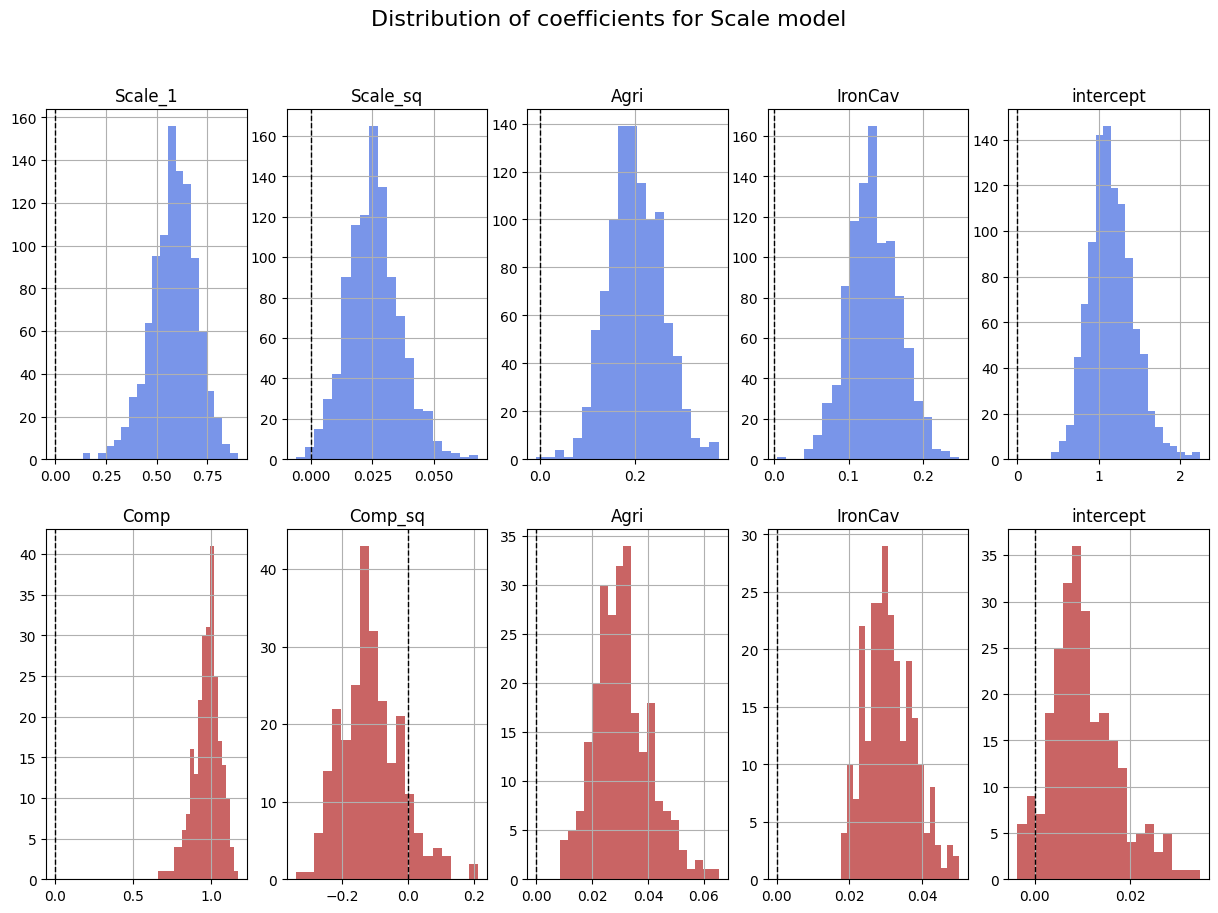

In [44]:
parameters = linear_models_scale["fit"].apply(lambda x: x.params)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))

fig.suptitle('Distribution of coefficients for Scale model', fontsize=16)
for c,col in enumerate(parameters.columns):
    # print(f"column: {col}")
    # print(f"mean: {parameters[col].mean()}")
    # print(f"standard error: {parameters[col].std()/np.sqrt(len(parameters))}")
    # calculate t-statistic and p-value
    t_stat = parameters[col].mean() / (parameters[col].std()/np.sqrt(len(parameters)))
    from scipy.stats import t
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=len(parameters)-1))
    # print(f"t-statistic: {t_stat}")
    # print(f"p-value: {p_value}\n")
    parameters[col].hist(bins=20, ax=axes[0,c], color='royalblue', alpha=0.7)
    axes[0,c].set_title(col)
    # plot vertical line at 0
    axes[0,c].axvline(x=0, color='black', linestyle='--', linewidth=1)
parameters = linear_models_comp["fit"].apply(lambda x: x.params)
for c,col in enumerate(parameters.columns):
    # print(f"column: {col}")
    # print(f"mean: {parameters[col].mean()}")
    # print(f"standard error: {parameters[col].std()/np.sqrt(len(parameters))}")
    # calculate t-statistic and p-value
    t_stat = parameters[col].mean() / (parameters[col].std()/np.sqrt(len(parameters)))
    from scipy.stats import t
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=len(parameters)-1))
    # print(f"t-statistic: {t_stat}")
    # print(f"p-value: {p_value}\n")
    parameters[col].hist(bins=20, ax=axes[1,c], color='firebrick', alpha=0.7)
    axes[1,c].set_title(col)
    axes[1,c].axvline(x=0, color='black', linestyle='--', linewidth=1)


In [35]:
parameters

,Scale_1,Comp_sq,Agri,IronCav,intercept
0,0.019910,0.867886,0.023575,0.026717,0.052295
1,0.011175,0.839922,0.058427,0.039618,0.070307
2,0.007853,0.830604,0.083113,0.044250,0.059995
3,0.005428,0.876385,0.097136,0.026095,0.073896
4,0.005269,0.839199,0.062786,0.045926,0.096059
...,...,...,...,...,...
995,0.021280,0.806691,0.039704,0.041008,0.036184
996,0.006299,0.863181,0.076714,0.041102,0.075164
997,0.012571,0.830421,0.057353,0.040381,0.072904
998,-0.004875,0.928118,0.081468,0.020839,0.108961


In [17]:
# def compute_bootstraps_imputation(self, cols, n_nga_bootstraps = 100, n_resid_boostraps = 20, use_duplicates = False, r2_lim = 0.0):

    #     # create empty dataframes
    #     all_imputed = pd.DataFrame(columns = self.scv.columns)
    #     original_scv = self.scv.copy()
    #     original_scv_imputed = self.scv_imputed.copy()
    #     if len(self.scv_imputed) == 0:
    #         original_scv_imputed = self.scv.copy()
    #     self.scv.loc[self.scv.NGA.isna(), 'NGA'] = "Unknown"
    #     ngas = self.scv.NGA.unique()

    #     for n in range(n_nga_bootstraps):
    #         # create a new dataframe with the same columns as the original scv
    #         new_scv = pd.DataFrame(columns = self.scv.columns)
            
    #         while len(new_scv) < len(self.scv):
    #             # sample a NGA from the original scv
    #             nga = np.random.choice(ngas, 1)[0]
    #             # add rows from the original scv to the new scv
    #             nga_rows = original_scv.loc[self.scv.NGA == nga].copy()
    #             if len(nga_rows) == 0:
    #                 continue
    #             new_scv = pd.concat([new_scv, nga_rows], ignore_index=True)
            
    #         for i in range(n_nga_bootstraps):
    #             # compute the imputation for the new scv
    #             self.scv = new_scv.copy()
    #             self.imputation_fits = pd.DataFrame([])
    #             self.scv_imputed = pd.DataFrame([])
    #             self.impute_missing_values(cols, use_duplicates=use_duplicates, r2_lim=r2_lim, add_resid=True)
    #             # add the imputed values to the all_imputed dataframe
    #             all_imputed = pd.concat([all_imputed, self.scv_imputed], ignore_index=True)

    #     self.scv_imputed = original_scv_imputed
    #     errors = pd.DataFrame(0, columns=cols, index=original_scv.index)
    #     # reconstruct imputed csv
    #     for index, row in original_scv.iterrows():
    #         # find positions of nans
    #         year = row['Year']
    #         polity = row['PolityID']
    #         row = row[cols]
    #         nan_cols = row[row.isna()].index
    #         non_nan_cols = row[row.notna()].index
    #         if len(non_nan_cols) == 0:
    #             continue
    #         for col in nan_cols:
    #             # find the rows in all_imputed where the columns are not nan
    #             imputed_vals = all_imputed.loc[(all_imputed['Year'] == year) & (all_imputed['PolityID'] == polity), col]
    #             imputed_vals = imputed_vals.dropna()
    #             # check if imputed_vals is empty    
    #             if len(imputed_vals) == 0:
    #                 continue
    #             # check if imputed_vals is a series
    #             else:
    #                 imputed_val = imputed_vals.mean()
    #                 self.scv_imputed.loc[index, col] = imputed_val
    #                 # calculate the error
    #                 errors.loc[index, col] = imputed_vals.std()
        
    #     self.scv = original_scv